In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import regex as re
import unicodedata
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle

In [37]:
data = pd.read_csv('../data/train_preprocess.tsv', sep='\t', header=None)
alay_dict = pd.read_csv('../data/new_kamusalay.csv', encoding='latin-1', header=None)
stopword_dict = pd.read_csv('../data/stopwordbahasa.csv', header=None)
id_stopword_dict = stopword_dict.rename(columns={0: 'stopword'})

In [38]:
data.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [39]:
data['text'] = data[0]
data['label'] = data[1]
data = data.drop([0, 1], axis=1)
data['label'].value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

# Data Pre-processing

In [40]:
alay_dict.head()

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


## Text Normalization

In [41]:
import re
import unicodedata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text)
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text


def normalize_alay(text):
    alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\KHADHI MUSAID SYAH\AppData\Local\Temp\ipykernel_23788\2392796772.py:14: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL


In [42]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    text = remove_unicode(text)
    text = remove_extra_spaces(text)

    return text

In [43]:
data['cleaned_text'] = data.text.apply(preprocess)

In [70]:
data['cleaned_text'].head()

0    warung milik usaha pabrik puluh kenal putih ba...
1    mohon ulama lurus k212 mmbri hujjah ai diwlh s...
2    lokasi strategis jalan sumatra bandung nya nya...
3    betapa bahagia nya unboxing paket barang nya b...
4    aduh mahasiswa sombong kasih kakak kuning ajar...
Name: cleaned_text, dtype: object

In [44]:
neg = data.loc[data['label'] == 'negative'].cleaned_text.tolist()
neu = data.loc[data['label'] == 'neutral'].cleaned_text.tolist()
pos = data.loc[data['label'] == 'positive'].cleaned_text.tolist()

neg_label = data.loc[data['label'] == 'negative'].label.tolist()
neu_label = data.loc[data['label'] == 'neutral'].label.tolist()
pos_label = data.loc[data['label'] == 'positive'].label.tolist()

In [45]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


# Feature Extracting

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

data_preprocessed = data.cleaned_text.tolist()

# Proses Feature Extraction
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(data_preprocessed)

X = tfidf_vect.fit_transform(data_preprocessed)
print ("Feature Extraction selesai")

pickle.dump(tfidf_vect, open("../pickle/feature_tfidf_stp.p", "wb"))

Feature Extraction selesai


## Splitting Dataset

In [58]:
data['label'].value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

In [111]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

label = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, stratify=label)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Training / Modeling

In [48]:
from sklearn.neural_network import MLPClassifier
from keras.callbacks import History  
import pickle

In [112]:
model = MLPClassifier(hidden_layer_sizes=(1024, 815, 500), activation='relu', solver='adam', alpha=0.0001, batch_size=500, learning_rate_init=0.001)
history = History()
model.fit(X_train_resampled, y_train_resampled)

print("Training Selesai")

Training Selesai


In [96]:
pickle.dump(model, open("../pickle/model_MLPClassifier.p", "wb"))

# Evaluation

In [81]:
from sklearn.metrics import mean_absolute_percentage_error, classification_report

## Confusion Matrix

In [113]:
test = model.predict(X_test)
test  

print ("Testing selesai")
print(classification_report(y_test, test))

Testing selesai
              precision    recall  f1-score   support

    negative       0.69      0.81      0.74       687
     neutral       0.62      0.54      0.58       230
    positive       0.90      0.83      0.87      1283

    accuracy                           0.80      2200
   macro avg       0.74      0.73      0.73      2200
weighted avg       0.80      0.80      0.80      2200



## Cross Validation

In [18]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [19]:
# # Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
# import numpy as np
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5,random_state=42,shuffle=True)

# train_accuracies = []
# val_accuracies = []

# y = label

# for iteration, data in enumerate(kf.split(X), start=1):

#     data_train   = X[data[0]]
#     target_train = y[data[0]]

#     data_test    = X[data[1]]
#     target_test  = y[data[1]]

#     clf = MLPClassifier(hidden_layer_sizes=(700, 512), activation='tanh', solver='adam', alpha=0.0001, batch_size=500, learning_rate_init=0.001)
#     clf.fit(data_train,target_train)

#     trained = clf.predict(data_train)
#     preds   = clf.predict(data_test)

#     train_acc = accuracy_score(target_train, trained)
#     val_acc = accuracy_score(target_test, preds)
    
#     train_accuracies.append(train_acc)
#     val_accuracies.append(val_acc)

#     # for the current fold only
#     accuracy = accuracy_score(target_test, preds)  

#     print("Training ke-", iteration)
#     print(classification_report(target_test, preds))
#     print("======================================================")


# # this is the average accuracy over all folds
# average_accuracy = np.mean(val_accuracies)

# print()
# print()
# print()
# print("Rata-rata Accuracy: ", average_accuracy)

d:\binar-bootcamp\platinum_challenge\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training ke- 1
              precision    recall  f1-score   support

    negative       0.69      0.68      0.69       680
     neutral       0.67      0.51      0.58       239
    positive       0.81      0.85      0.83      1281

    accuracy                           0.76      2200
   macro avg       0.72      0.68      0.70      2200
weighted avg       0.76      0.76      0.76      2200

Training ke- 2
              precision    recall  f1-score   support

    negative       0.65      0.68      0.67       706
     neutral       0.61      0.60      0.60       220
    positive       0.82      0.81      0.82      1274

    accuracy                           0.74      2200
   macro avg       0.69      0.69      0.69      2200
weighted avg       0.75      0.74      0.75      2200

Training ke- 3
              precision    recall  f1-score   support

    negative       0.68      0.69      0.68       682
     neutral       0.71      0.57      0.63       215
    positive       0.83      0

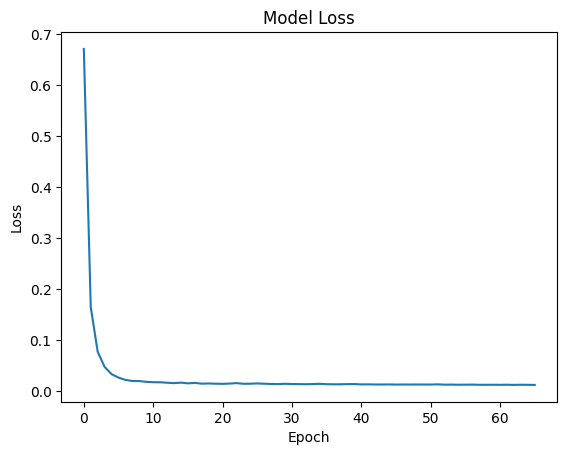

In [20]:
# # Plot the loss curve
# plt.plot(model.loss_curve_)
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.show()

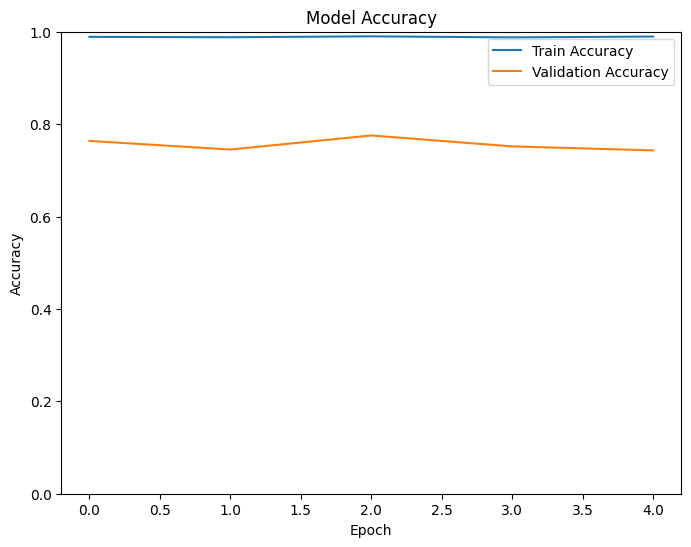

In [21]:
# plt.figure(figsize=(8, 6))
# plt.plot(train_accuracies, label='Train Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.ylim(0, 1)
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()

# Prediction

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import regex as re
import unicodedata
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle

In [62]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text)
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text


def normalize_alay(text):
    alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\KHADHI MUSAID SYAH\AppData\Local\Temp\ipykernel_23788\1136009243.py:11: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL


In [114]:
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_text = """
Peluncuran produk terbaru mengalami banyak kendala dan tidak sesuai dengan harapan. Banyak pelanggan mengeluhkan masalah kualitas, dan waktu pengiriman yang tertunda membuat kepercayaan terhadap perusahaan menurun. Ini adalah situasi yang sangat mengecewakan bagi semua pihak
"""

def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text)
    text = stemming(text)
    text = remove_stopword(text)
    text = remove_unicode(text)
    text = remove_extra_spaces(text)

    return text

sentiment = ['negative', 'neutral', 'positive']

file = open("../pickle/feature_tfidf_stp.p",'rb')
feature = pickle.load(file)
file.close()

file = open("../pickle/model_MLPClassifier.p",'rb')
new_model = pickle.load(file)
file.close()

# Feature Extraction
text = feature.transform([preprocess(input_text)])

# Kita prediksi sentimennya
result = new_model.predict(text)[0]
result_prob = new_model.predict_proba(text)[0]

print("Sentiment:")
print()
print(result)
print ()
print(max(result_prob))

Sentiment:

negative

0.9999975975951754


In [65]:
new_model.predict_proba(text)[0]

array([3.07356050e-01, 5.08797123e-04, 6.92135153e-01])